<a href="https://colab.research.google.com/github/abhijitpanda890/ML1-Sentiment-analysis-and-emotion-detection-/blob/main/Sentiment_Analysis(Yelp_Polarity_reviews).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import re
import shutil
import string
import tqdm
from tensorflow.keras import Model, preprocessing
from tensorflow.keras.layers import Dot, Embedding , Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import os

import tensorflow_datasets as tfds
import tensorflow as tf

from keras import backend as K


tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('yelp_polarity_reviews', with_info=True,
                          as_supervised=True) #download the dataset
train_dataset, test_dataset = dataset['train'], dataset['test'] #segregate the train and test datasets

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"The Groovy P. and I ventured to his old stomping grounds for lunch today.  The '5 and Diner' on 16th St and Colter left me with little to ask for.  Before coming here I had a preconceived notion that 5 & Diners were dirty and nasty. Not the case at all.\\n\\nWe walk in and let the waitress know we want to sit outside (since it's so nice and they had misters).  We get two different servers bringing us stuff (talk about service) and I ask the one waitress for recommendations.  I didn't listen to her, of course, and ordered the Southwestern Burger w/ coleslaw and started with a nice stack of rings.\\n\\nThe Onion Rings were perfectly cooked.  They looked like they were prepackaged, but they were very crispy and I could actually bite through the onion without pulling the entire thing out (don't you hate that?!!!)\\n\\nThe Southwestern Burger was order Medium Rare and was cooked accordingly.  Soft, juicy, and pink with a nice crispy browned outer layer that can only be achieved on 

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This isn't a review, it's a love story.\\n\\nFour Peaks and I have had the most amazing relationship over the past four years. We were first introduced back in 2007. It was the summer before my senior year of college and I was barely 21. It was not love at first sight. Oh, no no. I was new to the world of beer and it wasn't my beverage of choice (though a Peach Ale on a hot night was always delicious).\\n\\nBut this isn't a place you go to solely for the beer.  Good food was nothing new to me, and this is where Four Peaks really shines. My friends would get together and drink, and I would eat. And eat. And eat. Hummus, pizza, bruchetta (you have to get the shrimp and goat cheese!), burgers, fries. My heart flutters for their Salmon BLT.\\n\\nAnd then I got into beer. This is when Four Peaks and I began our unstoppable love. I'm truly lucky to live close enough to stop by regularly, but far enough away to not become a fat alcoholic. All of the beers are perfect in their own w

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)  #preprocessing and vectorization of data
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]
encoded_example = encoder(example)[:3].numpy() #modified data after text vectorization
encoded_example

array([[ 16, 403,   6, ...,   0,   0,   0],
       [ 59,  25, 110, ...,   0,   0,   0],
       [  2,  30, 599, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This isn't a review, it's a love story.\\n\\nFour Peaks and I have had the most amazing relationship over the past four years. We were first introduced back in 2007. It was the summer before my senior year of college and I was barely 21. It was not love at first sight. Oh, no no. I was new to the world of beer and it wasn't my beverage of choice (though a Peach Ale on a hot night was always delicious).\\n\\nBut this isn't a place you go to solely for the beer.  Good food was nothing new to me, and this is where Four Peaks really shines. My friends would get together and drink, and I would eat. And eat. And eat. Hummus, pizza, bruchetta (you have to get the shrimp and goat cheese!), burgers, fries. My heart flutters for their Salmon BLT.\\n\\nAnd then I got into beer. This is when Four Peaks and I began our unstoppable love. I'm truly lucky to live close enough to stop by regularly, but far enough away to not become a fat alcoholic. All of the beers are perfect in their own

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True), #parameters:size of vocabulary, output-dimensions, mask(explained in README)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),#RNN Layer with 64 LSTM units
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),#RNN Layer with 32 LSTM units
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),# using the BinaryCrossentropy as loss function for a binary classifier
              optimizer=tf.keras.optimizers.Adam(1e-4), #adam as optimizer
              metrics=['accuracy', f1_m,precision_m, recall_m])

In [64]:
 history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
2188/2188 [==============================] - 527s 241ms/step - loss: 0.1669 - accuracy: 0.9298 - f1_m: 0.9276 - precision_m: 0.9532 - recall_m: 0.9041 - val_loss: 0.1707 - val_accuracy: 0.9264 - val_f1_m: 0.9258 - val_precision_m: 0.9517 - val_recall_m: 0.9019
Epoch 2/10
2188/2188 [==============================] - 529s 242ms/step - loss: 0.1623 - accuracy: 0.9318 - f1_m: 0.9298 - precision_m: 0.9547 - recall_m: 0.9069 - val_loss: 0.1729 - val_accuracy: 0.9214 - val_f1_m: 0.9190 - val_precision_m: 0.9646 - val_recall_m: 0.8781
Epoch 3/10
2188/2188 [==============================] - 522s 238ms/step - loss: 0.1582 - accuracy: 0.9336 - f1_m: 0.9316 - precision_m: 0.9561 - recall_m: 0.9091 - val_loss: 0.1656 - val_accuracy: 0.9271 - val_f1_m: 0.9254 - val_precision_m: 0.9645 - val_recall_m: 0.8900
Epoch 4/10
2188/2188 [==============================] - 529s 242ms/step - loss: 0.1548 - accuracy: 0.9354 - f1_m: 0.9335 - precision_m: 0.9570 - recall_m: 0.9119 - val_loss: 0.1599 - v

In [65]:
test_loss, test_acc, f1_score, precision, recall = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', f1_score)




149/149 [==============================] - 13s 86ms/step - loss: 0.1476 - accuracy: 0.9415 - f1_m: 0.9405 - precision_m: 0.9503 - recall_m: 0.9313
Test Loss: 0.14759980142116547
Test Accuracy: 0.9415000081062317
Test Precision: 0.9503315091133118
Test Recall: 0.9313362836837769
Test F1 Score: 0.9405220746994019


(0.0, 0.17461035400629044)

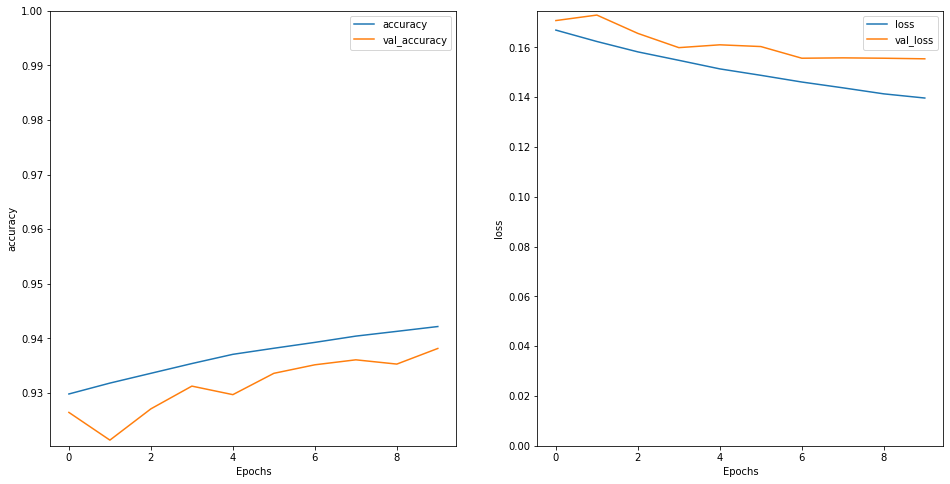

In [66]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [67]:

!mkdir -p saved_model
model.save('saved_model/SA_model')

INFO:tensorflow:Assets written to: saved_model/SA_model/assets


INFO:tensorflow:Assets written to: saved_model/SA_model/assets
